In [1]:
!pip install -q tensorflow-addons
!pip install -q tensorflow-probability
!pip install -q tensorflow-io

In [2]:
import os
import pathlib
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_addons as tfa
import tensorflow_probability as tfp

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import matplotlib.pyplot as plt

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
data_dir = pathlib.Path("/kaggle/input/audio-mnist/data")

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['47' '17' '19' '22' '35' '50' '23' '07' '10' '36' '05' '20' '06' '45'
 '60' '27' '41' '39' '02' '32' '25' '42' '52' '38' '12' '55' '04' '49'
 '31' '53' '34' '18' '28' '56' '16' '13' '26' '08' '15' '43' '09' '58'
 '59' '30' '14' '03' '57' '46' '21' '44' '40' '11' '37' '51' '01'
 'audioMNIST_meta.txt' '33' '54' '48' '29' '24']


In [5]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=32000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 30000 files belonging to 60 classes.
Using 24000 files for training.
Using 6000 files for validation.

label names: ['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '14'
 '15' '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28'
 '29' '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42'
 '43' '44' '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56'
 '57' '58' '59' '60']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of (batch, samples, channels).

In [6]:
train_ds.element_spec

(TensorSpec(shape=(None, 32000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the tf.squeeze function to drop the extra axis:

In [7]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [8]:
train_ds.element_spec

(TensorSpec(shape=(None, 32000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

The utils.audio_dataset_from_directory function only returns up to two splits. It's a good idea to keep a test set separate from your validation set. Ideally you'd keep it in a separate directory, but in this case you can use Dataset.shard to split the validation set into two halves. Note that iterating over any shard will load all the data, and only keep its fraction.

In [9]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [10]:
for example_audio, example_labels in train_ds.take(1):  
    print(example_audio.shape)
    print(example_labels.shape)

(64, 32000)
(64,)


lets plot the audio waveform

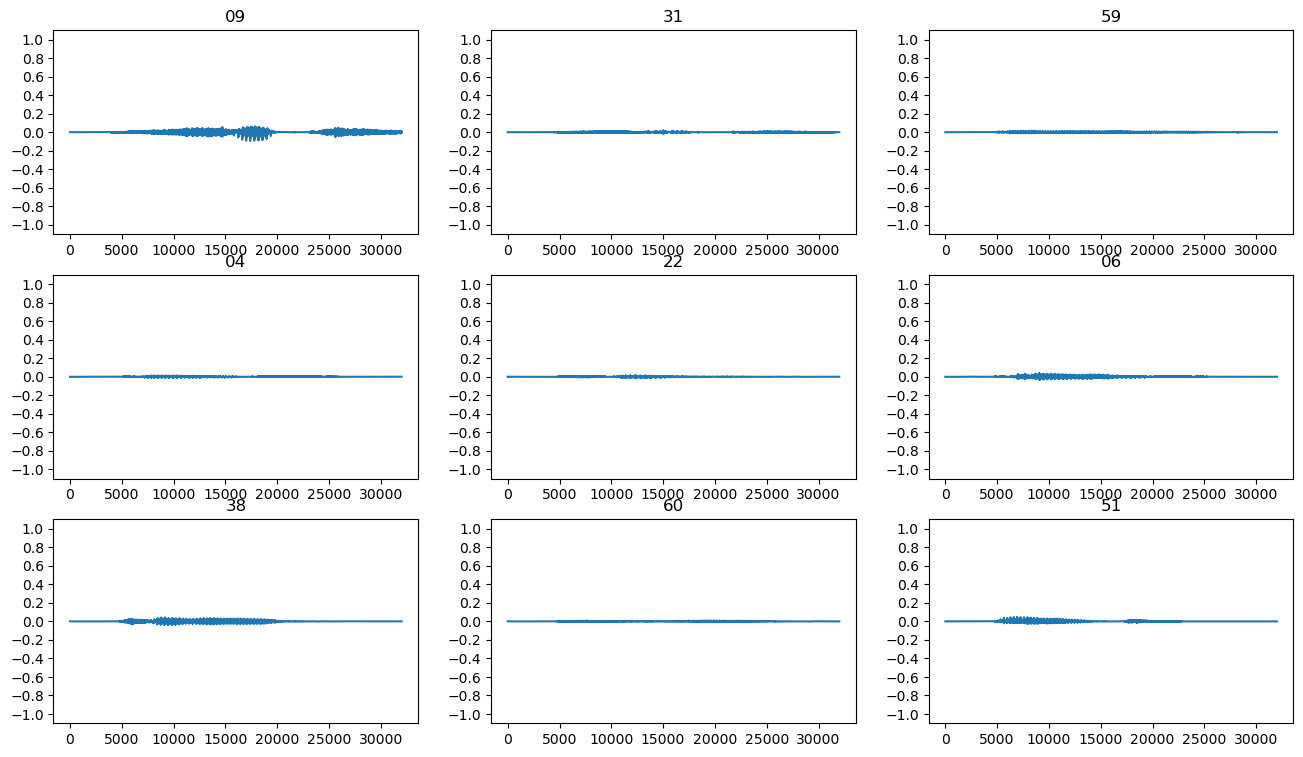

In [11]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    if i>=n:
        break
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(example_audio[i].numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label_names[example_labels[i]]
    ax.set_title(label)
    ax.set_ylim([-1.1,1.1])

plt.show()

** waveforms to spectrograms**

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the short-time Fourier transform (STFT) to convert the waveforms to as spectrograms, which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (tf.signal.fft) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (tf.signal.stft) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using tf.zeros).
When calling tf.signal.stft, choose the frame_length and frame_step parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to this Coursera video on audio signal processing and STFT.
The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying tf.abs on the output of tf.signal.stft.

In [12]:
def get_spectrogram(waveform):
     # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [13]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=32000))

Label: 09
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Label: 31
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Label: 59
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [14]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

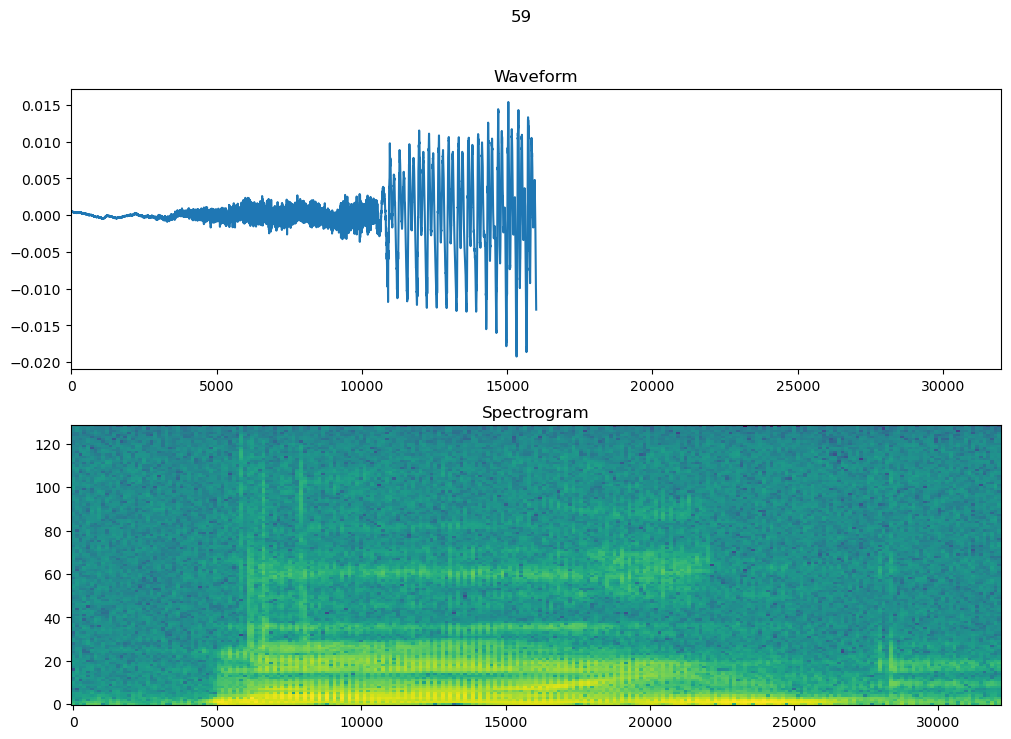

In [31]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 32000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogramn datasets from the audio datasets:

In [16]:
def make_spec_ds(ds):
    return ds.map(map_func=lambda audio,label: (get_spectrogram(audio), label),
                   num_parallel_calls=tf.data.AUTOTUNE)

In [17]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [18]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

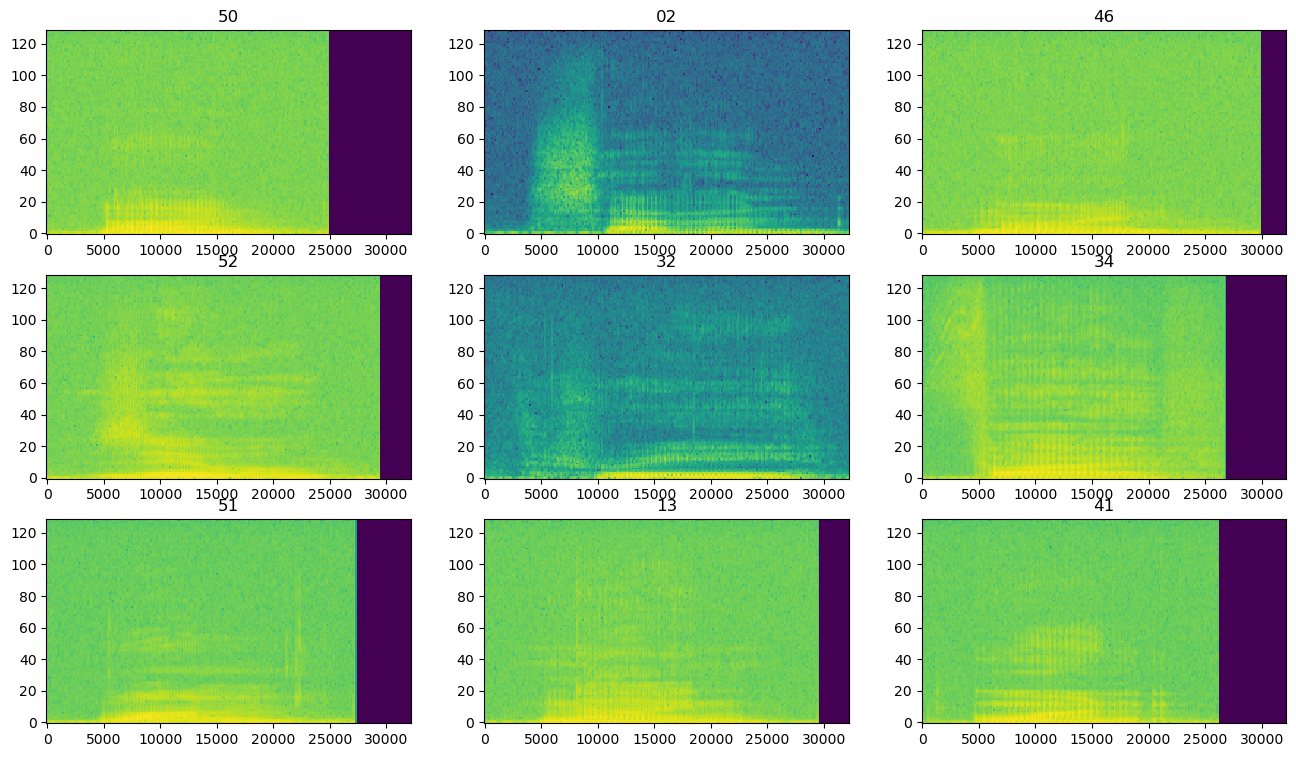

In [19]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

Build and train the model

Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model:

In [20]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your tf.keras.Sequential model will use the following Keras preprocessing layers:

tf.keras.layers.Resizing: to downsample the input to enable the model to train faster.
tf.keras.layers.Normalization: to normalize each pixel in the image based on its mean and standard deviation.
For the Normalization layer, its adapt method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).


For the Normalization layer, its adapt method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [21]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (249, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [23]:
EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20


2023-04-06 23:28:48.134796: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


375/375 [==============================] - 15s 31ms/step - loss: 3.3568 - accuracy: 0.1488 - val_loss: 2.2175 - val_accuracy: 0.4582
Epoch 2/20
375/375 [==============================] - 3s 7ms/step - loss: 2.1689 - accuracy: 0.3997 - val_loss: 1.2463 - val_accuracy: 0.6902
Epoch 3/20
375/375 [==============================] - 3s 8ms/step - loss: 1.6051 - accuracy: 0.5425 - val_loss: 0.8675 - val_accuracy: 0.7874
Epoch 4/20
375/375 [==============================] - 3s 7ms/step - loss: 1.2930 - accuracy: 0.6207 - val_loss: 0.6842 - val_accuracy: 0.8332
Epoch 5/20
375/375 [==============================] - 3s 7ms/step - loss: 1.1230 - accuracy: 0.6706 - val_loss: 0.5282 - val_accuracy: 0.8750
Epoch 6/20
375/375 [==============================] - 3s 7ms/step - loss: 0.9833 - accuracy: 0.7051 - val_loss: 0.4467 - val_accuracy: 0.8874
Epoch 7/20
375/375 [==============================] - 3s 7ms/step - loss: 0.8955 - accuracy: 0.7325 - val_loss: 0.4123 - val_accuracy: 0.9071
Epoch 8/20
375/

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

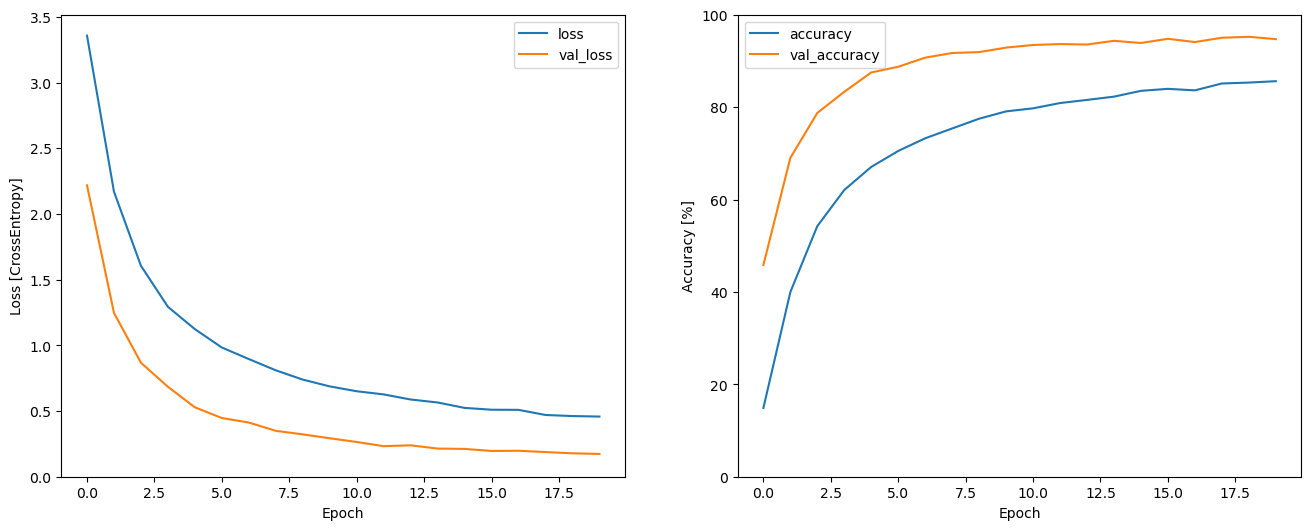

In [24]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

Evaluate the model performance
Run the model on the test set and check the model's performance:

In [25]:
model.evaluate(test_spectrogram_ds, return_dict=True)

47/47 [==============================] - 10s 205ms/step - loss: 0.1902 - accuracy: 0.9541


{'loss': 0.19018100202083588, 'accuracy': 0.9541223645210266}

Display a confusion matrix
Use a confusion matrix to check how well the model did classifying each of the commands in the test set:

In [26]:
y_pred=model.predict(test_spectrogram_ds)

47/47 [==============================] - 0s 4ms/step


In [27]:
y_pred = tf.argmax(y_pred, axis=1)

In [28]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

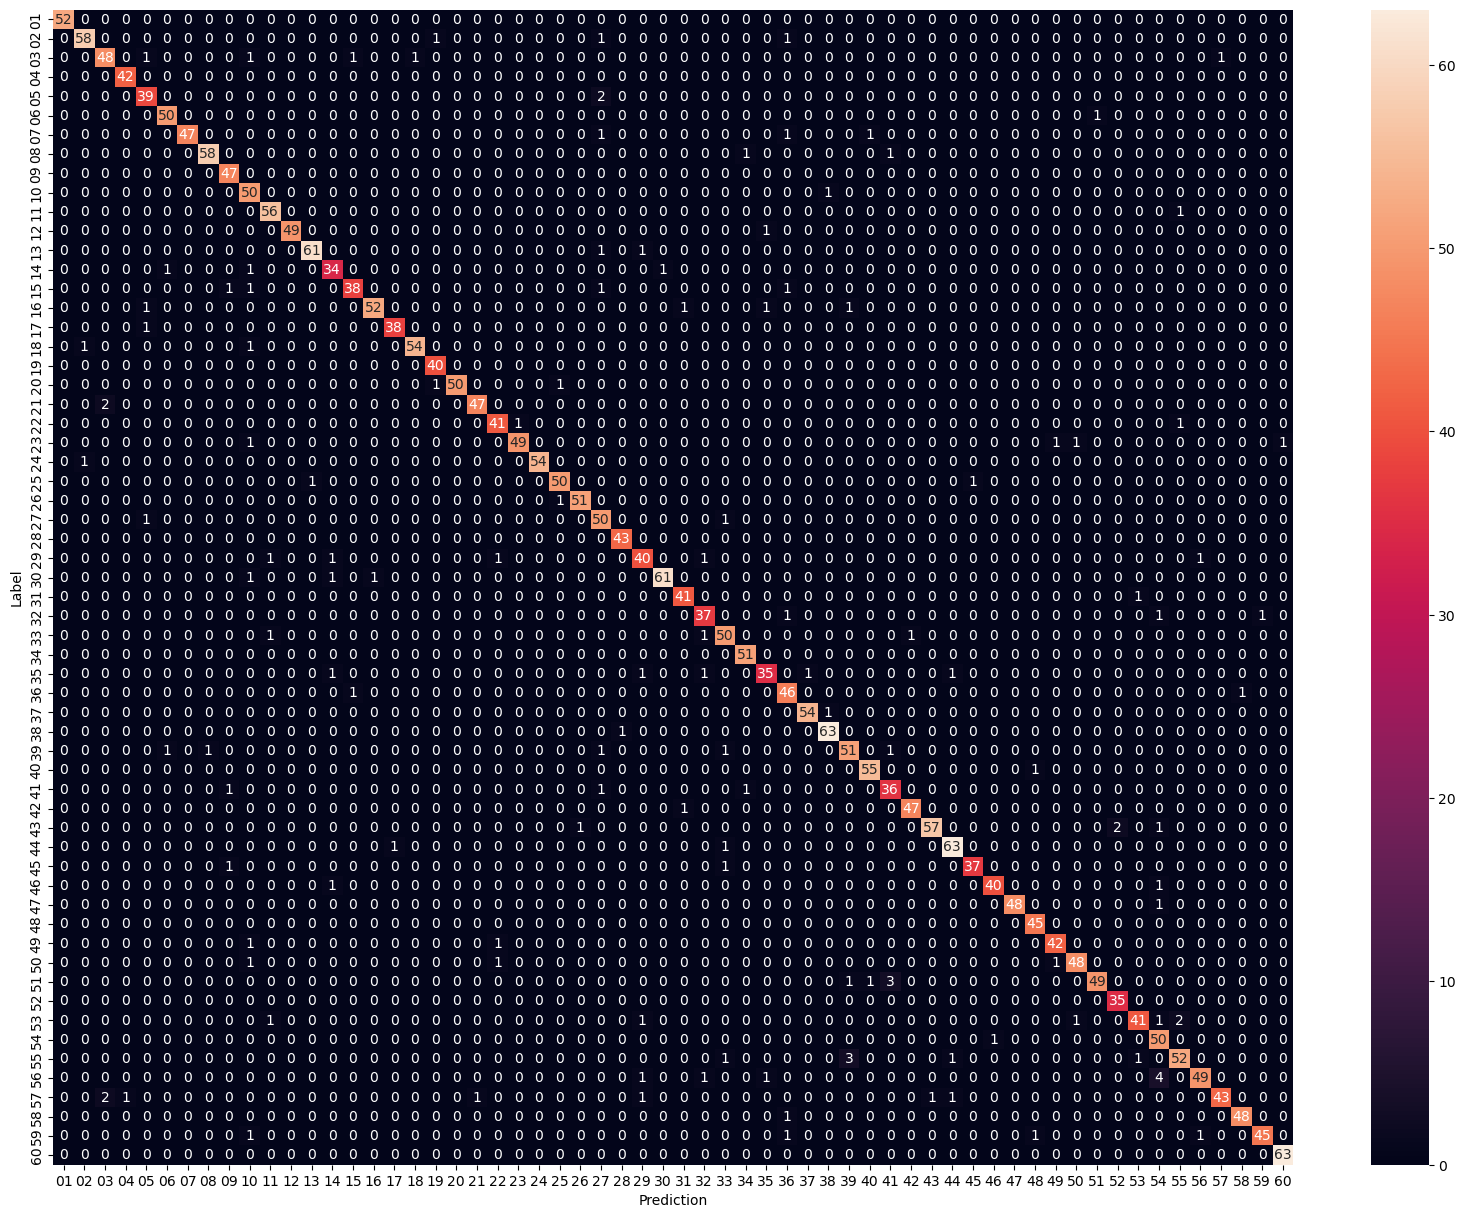

In [29]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20, 15))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Run inference on an audio file
Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

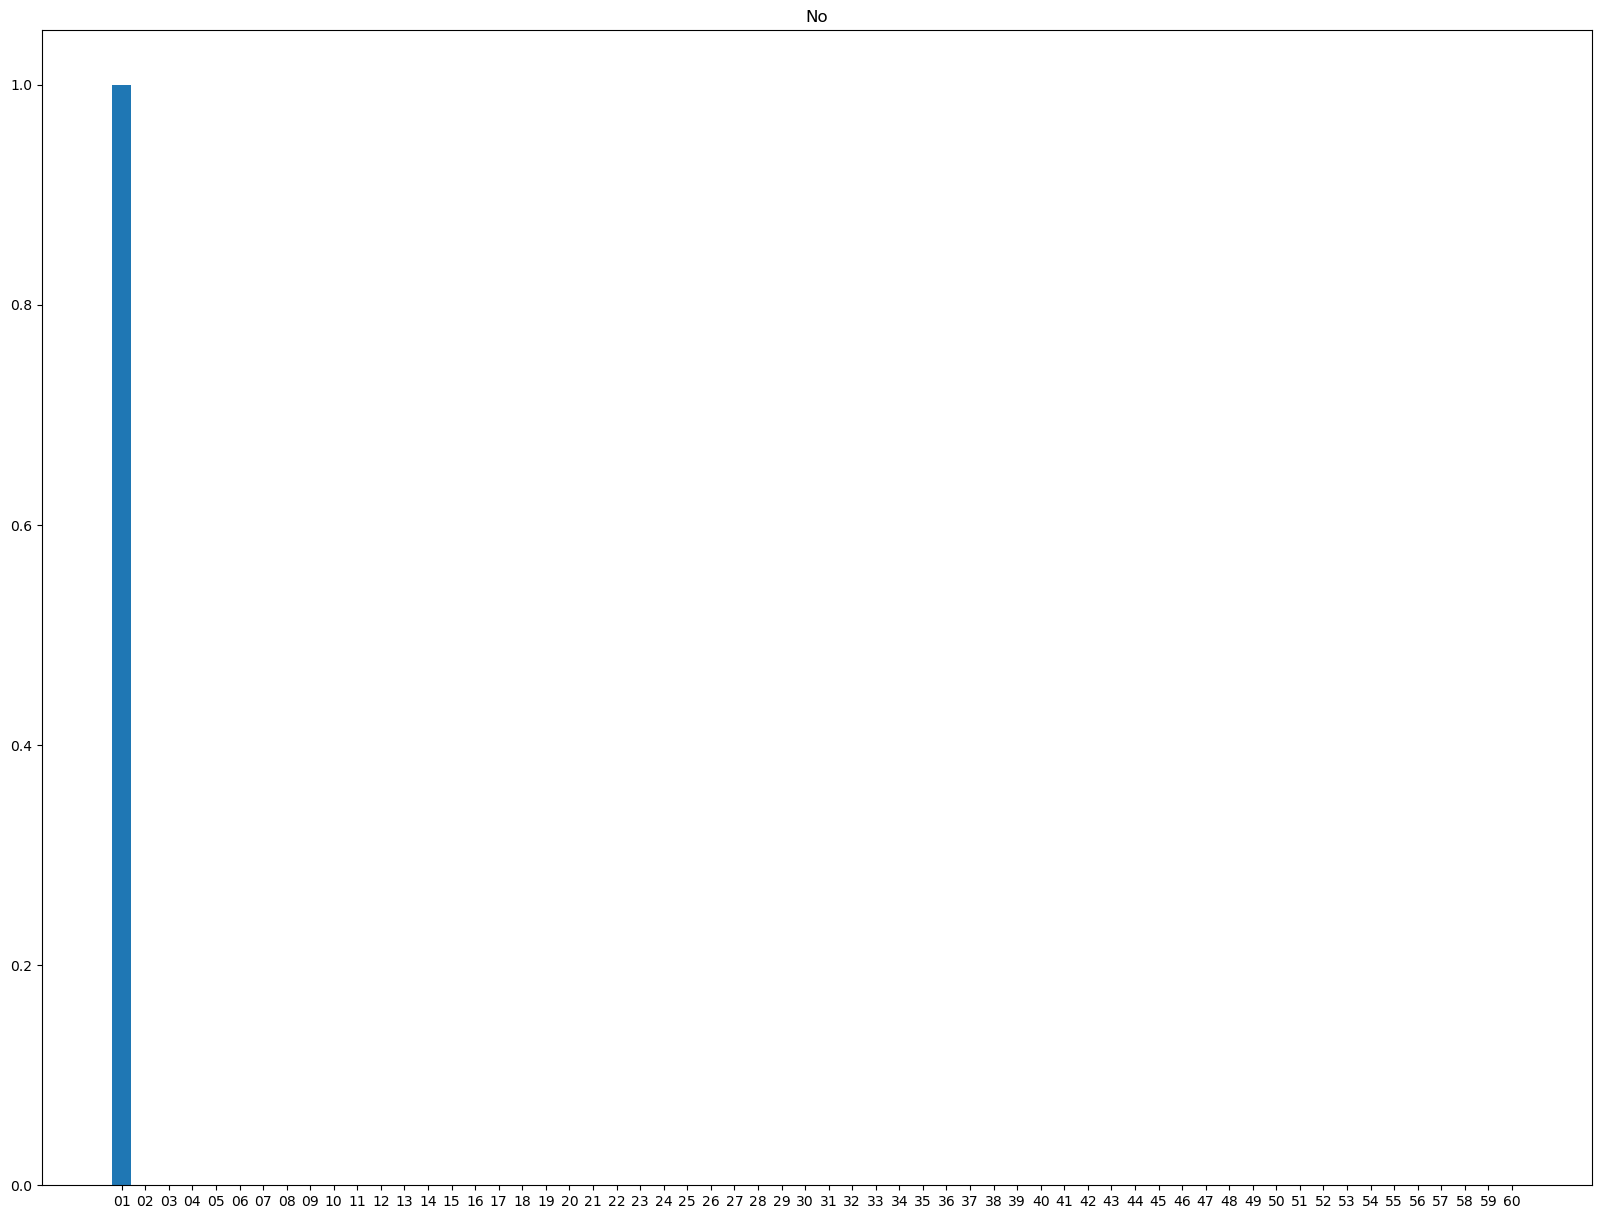

In [32]:
x = "/kaggle/input/audio-mnist/data/01/0_01_0.wav"
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=32000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ["01","02","03","04","05","06","07","08","09","10",
           "11","12","13","14","15","16","17","18","19","20",
           "21","22","23","24","25","26","27","28","29","30",
           "31","32","33","34","35","36","37","38","39","40",
           "41","42","43","44","45","46","47","48","49","50",
           "51","52","53","54","55","56","57","58","59","60",]
plt.figure(figsize=(20, 15))
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

Export the model with preprocessing:
The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [35]:
class ExportModel(tf.Module):
    def __init__(self, model):
        self.model = model

        # Accept either a string-filename or a batch of waveforms.
        # YOu could add additional signatures for a single wave, or a ragged-batch. 
        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=(), dtype=tf.string))
        self.__call__.get_concrete_function(
           x=tf.TensorSpec(shape=[None, 32000], dtype=tf.float32))


    @tf.function
    def __call__(self, x):
        # If they pass a string, load the file and decode it. 
        if x.dtype == tf.string:
            x = tf.io.read_file(x)
            x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=32000,)
            x = tf.squeeze(x, axis=-1)
            x = x[tf.newaxis, :]

        x = get_spectrogram(x)  
        result = self.model(x, training=False)

        class_ids = tf.argmax(result, axis=-1)
        class_names = tf.gather(label_names, class_ids)
        return {'predictions':result,
                'class_ids': class_ids,
                'class_names': class_names}

In [36]:
export = ExportModel(model)
export(tf.constant(str("/kaggle/input/audio-mnist/data/06/0_06_0.wav")))

{'predictions': <tf.Tensor: shape=(1, 60), dtype=float32, numpy=
 array([[-23.45504   ,  -0.51090086, -19.16905   , -24.988884  ,
          -9.943419  ,  12.008052  ,   2.550547  , -17.180267  ,
          -9.857229  , -29.938421  ,  -4.0041704 , -18.078203  ,
          -0.51189125,  -7.9595857 , -22.962435  ,   0.35507917,
         -20.387695  , -18.591833  ,   1.5885715 , -11.338373  ,
         -29.588602  ,  -5.0698867 , -19.596403  ,  -6.105201  ,
          -0.84584785, -18.876825  ,  -0.34184402, -16.637032  ,
          -7.971394  ,  -9.804633  ,   2.0010219 , -12.584769  ,
          -3.252022  ,  -8.885968  ,  -4.7204185 , -18.728594  ,
         -17.208273  ,  -7.689386  ,  -0.06494334,  -0.565205  ,
          -6.866699  ,  -3.5427768 , -37.48154   , -21.010178  ,
          -6.513714  , -13.066299  , -30.476753  ,  -3.624361  ,
         -21.096289  , -22.176798  ,   7.890066  , -36.343327  ,
         -11.666311  , -10.491716  ,  -4.17523   , -33.142128  ,
         -38.89379   , -2

Save and reload the model, the reloaded model gives identical output:

In [37]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'predictions': <tf.Tensor: shape=(1, 60), dtype=float32, numpy=
 array([[ 14.204651 ,  -2.2324014, -16.33453  , -14.208619 , -11.097935 ,
         -10.227353 , -15.577797 , -11.043309 , -17.01399  ,  -7.2214813,
          -6.7441225, -10.301668 ,  -4.8279014,  -9.600461 , -10.4238205,
         -15.408067 ,  -6.5310826, -17.49499  , -17.265438 , -10.020961 ,
           3.78022  ,  -6.63577  , -24.212082 ,   6.4331226,  -1.4824098,
           2.8339164, -11.942262 ,  -3.942767 ,   2.832005 , -11.683081 ,
         -13.603748 , -11.392899 ,  -7.7934337, -17.597307 ,  -3.5331817,
          -8.169116 , -12.604562 ,  -5.5100827, -17.718256 ,  -3.034348 ,
         -13.821264 , -17.731289 ,   1.5827894, -16.567974 ,  -8.077002 ,
         -19.821404 ,  -1.1851399, -32.786873 , -14.930749 , -19.14437  ,
         -13.659963 ,  -2.6915216, -20.465487 , -17.144165 ,  -8.737201 ,
          -2.0601206,  -8.116854 , -12.614052 ,   3